# Experiment: group by score

One vs All with resampling.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

In [37]:
#data = pd.read_csv('data/red_normal.csv')
#data = pd.read_csv('data/red_data.csv')
#data = pd.read_csv('data/white_normal.csv')
#data = pd.read_csv('data/white_data.csv')
data = pd.read_csv('data/wine_normal.csv')
#data = pd.read_csv('data/wine_data.csv')

In [38]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,type_red,quality
0,-1.564967,-2.115822,-0.613053,-0.412341,-0.381414,-1.025732,-0.973236,0.248294,1.137303,-0.261526,-1.067971,0,5
1,-0.987675,1.452634,-1.288368,0.404591,-0.391592,0.402953,-0.159545,-0.660550,1.741648,1.367797,1.761353,1,7
2,-0.772730,1.646757,-0.613053,-0.392625,1.147534,1.335430,1.591586,-0.009153,0.541278,0.264209,-0.580412,0,4
3,-0.645329,-0.550403,-0.282528,-0.865805,0.433714,-0.578715,-0.432035,-0.664473,0.342604,-0.173903,-0.092853,0,6
4,-0.298454,-0.583142,2.099702,-0.898276,5.590264,0.489629,0.899821,0.293176,-1.496978,3.845571,-1.053784,1,5


In [39]:
# Optionally generate interaction features x*y and x**2
if True:
    from itertools import combinations
    
    old_features = [name for name in data.columns if not 'type' in name and name != "quality"]
    
    for feature1, feature2 in combinations(old_features, 2):
        temp = data[feature1] * data[feature2]
        data.insert(data.shape[1]-1, feature1 + 'x' + feature2, temp)

    for name in old_features:
         data.insert(data.shape[1]-1, name + '**2', data[name]*data[name])   

In [40]:
data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [41]:
if False:
    for name in (name for name in data.columns if name != "quality" and name != "type_red"):
        sns.boxplot(x="quality", y=name, hue="type_red", data=data)
        plt.show()
    sns.boxplot(y="quality", x="type_red", data=data)
    plt.show()

In [42]:
X, y = data.ix[:,:-1], data['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
qualities = sorted(data.quality.unique())
qualities

[3, 4, 5, 6, 7, 8, 9]

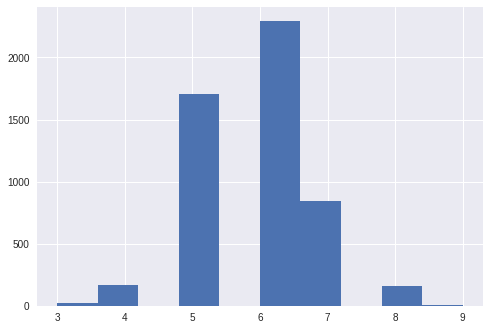

In [45]:
y_train.hist()
plt.show()

In [46]:
y_train.value_counts()

6    2293
5    1707
7     843
4     168
8     158
3      24
9       4
Name: quality, dtype: int64

Create one model for segment: Bad (<=4), 5, 6, 7, Good (>=8) 


In [47]:
split = ['<=4', '5', '6', '7', '>=8']

In [48]:
X_train.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,...,volatile_acidity**2,citric**2,sugar**2,chlorides**2,free_SD**2,total_SD**2,density**2,pH**2,sulphates**2,alcohol**2
3465,0.563469,-0.067173,-0.199897,-0.944669,-0.232029,0.412294,0.815080,-0.744716,0.011479,0.176587,...,0.004512,0.039959,0.892399,0.053838,0.169986,0.664356,0.554602,0.000132,0.031183,0.518033
2770,0.904922,2.060810,-0.778315,-1.023532,-0.232029,-2.049052,-0.808523,-0.677847,-0.915669,-1.751110,...,4.246939,0.605774,1.047618,0.053838,4.198614,0.653709,0.459476,0.838451,3.066386,0.053910
4867,0.447597,-0.301232,-0.447790,-0.885521,-0.870999,-0.084188,-1.090889,-0.878455,-0.584545,-0.874884,...,0.090741,0.200516,0.784148,0.758639,0.007088,1.190038,0.771683,0.341693,0.765422,0.098248
3456,-0.901412,1.343794,-2.430937,-1.003816,-0.537296,-0.578715,-0.408505,-0.584230,0.342604,1.052813,...,1.805782,5.909454,1.007647,0.288687,0.334911,0.166876,0.341324,0.117377,1.108415,0.249153
1433,-1.562026,0.589522,-1.391037,-1.063744,0.241695,0.311323,0.658659,-1.296368,1.741648,-0.815004,...,0.347536,1.934984,1.131551,0.058416,0.096922,0.433832,1.680570,3.033336,0.664231,0.240842


In [49]:
y_train.head()

3465    6
2770    6
4867    6
3456    6
1433    5
Name: quality, dtype: int64

In [50]:
train = pd.concat([X_train, y_train], axis=1)

In [51]:
train_split = {}
for name in split:
    temp = train['quality']
    if name == '<=4':
        train['quality'] = train.quality <= 4 
    elif name == '>=8':
        train['quality'] = train.quality >= 8
    else:
        train['quality'] = train.quality == int(name)
    train.quality.astype(int)
    train_split[name] = train.copy()
    train['quality'] = temp

In [52]:
def balanceData(train_split):
    for key in train_split:
        df = train_split[key]
        #df = df.sample(n=train.quality.value_counts().max(), replace=True)
        df_pos = df[df.quality == True]
        df_neg = df[df.quality == False]
        n = df_neg.shape[0]
        f = n//4
        df_pos = df_pos.sample(n=f, replace=True)
        df = pd.concat([df_neg, df_pos]).sample(frac=1)
        train_split[key] = df

balanceData(train_split)        

In [53]:
clfs = {}
for name in split:
    clf = LogisticRegression(penalty='l1', C=100, n_jobs=-1)
    #print(name)
    #print( train_split[name].head())
    #print()
    X_train = train_split[name].ix[:,:-1]
    y_train = train_split[name].quality
    clf.fit(X_train, y_train)
    clfs[name] = clf

In [54]:
# Make prediction
pred = pd.DataFrame(columns=['<=4', '5', '6', '7', '>=8'])
for i in range(X_test.shape[0]):
    current_pred = []
    for idx, name in enumerate(split):
        temp = clfs[name].predict_proba(X_test.iloc[i].values.reshape(1,-1))[0][1]
        #temp += 0.05
        current_pred.append(temp)
    current_pred = pd.DataFrame(pd.Series(current_pred).values.reshape(1,-1), index=[X_test.index[i]], columns=split)
    pred = pd.concat([pred, current_pred], axis=0)

In [55]:
# Weighted prediction
new_col = []
for i in range(pred.shape[0]):
    l = len(split)
    x = np.array(pred.iloc[i][:l])
    temp = np.inner(x, np.array(range(4,9)))/np.sum(x)
    new_col.append(temp)  
pred.insert(pred.shape[1] - 1, 'weighted', new_col)

In [56]:
pred.head()

,<=4,5,6,7,weighted,>=8
3831,0.668667,0.260894,0.051811,0.034272,4.462777,0.000759
970,0.158081,0.336216,0.150871,0.055462,5.158965,0.002697
4751,0.117180,0.072449,0.127565,0.522697,6.921815,0.517848
5281,0.019445,0.128661,0.286821,0.223515,6.663948,0.285324
3128,0.021696,0.089987,0.341184,0.226743,6.543314,0.189386


## Weighted

In [57]:
print("MAE =", mean_absolute_error(y_test, pred['weighted'].apply(np.rint)))
print("Acc. =", accuracy_score(y_test, pred['weighted'].apply(np.rint)))

MAE = 0.550769230769
Acc. = 0.5


In [58]:
confusion_matrix(y_test, pred['weighted'].apply(np.rint))

array([[  0,   2,   3,   1,   0,   0,   0],
       [  0,  15,  26,   7,   0,   0,   0],
       [  0,  17, 272, 114,  27,   1,   0],
       [  0,   1, 155, 229, 157,   1,   0],
       [  0,   1,  11,  89, 134,   1,   0],
       [  0,   0,   0,   9,  26,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0]])

In [59]:
pred['weighted'].apply(np.rint).value_counts()

5.0    467
6.0    449
7.0    345
4.0     36
8.0      3
Name: weighted, dtype: int64

In [60]:
y_test.value_counts()

6    543
5    431
7    236
4     48
8     35
3      6
9      1
Name: quality, dtype: int64

In [61]:
data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64